In [1]:
from music21 import *

In [2]:
#read MIDI files return notes
def read_midi(file):
    # initialize     
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file - converting to music21 objects(Scores)
    midi = converter.parse(file)
  
    #separate as instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
        #Piano and Guitar elements
        if ('Piano' in str(part) or ('Guitar' in str(part))): 
            notes_to_parse = part.recurse() 
      
            #note or chord
            for element in notes_to_parse:
                
                #handling a note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #handling a chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [3]:
import numpy as np
import os

In [9]:
path = '/content/midi/'

In [10]:
#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

In [11]:
#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

<ipython-input-11-371224d13292>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi(path+i) for i in files])


In [12]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

344


In [14]:
from collections import Counter
import matplotlib.pyplot as plt

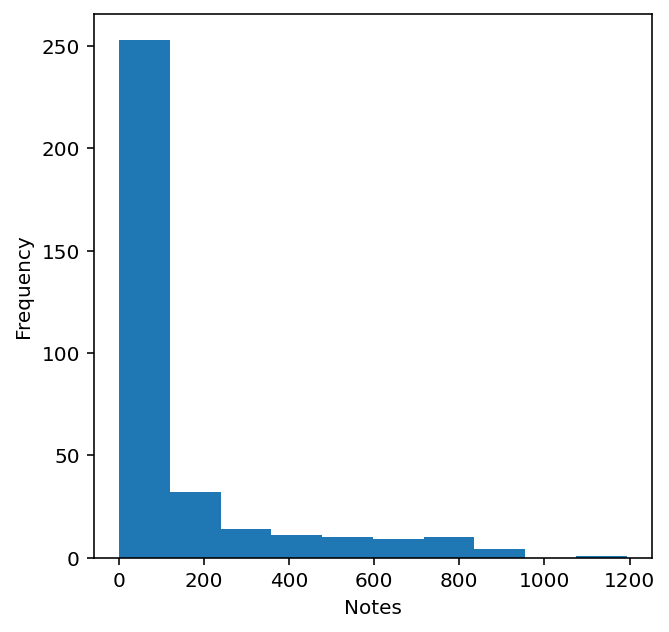

In [15]:
freq = dict(Counter(notes_))
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))
plt.hist(no)
plt.xlabel('Notes')
plt.ylabel('Frequency')
plt.show()

In [17]:
frequent_notes = [note_ for note_, count in freq.items() if count>=40]
print(len(frequent_notes))

135


In [18]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

<ipython-input-18-2fa7923ce1b3>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_music = np.array(new_music)


In [19]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [20]:
# converting notes to ints
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [21]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [22]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [23]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=42)

In [24]:
import keras
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

In [28]:
K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(256,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(64,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

In [30]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           13500     
                                                                 
 conv1d (Conv1D)             (None, 32, 256)           77056     
                                                                 
 dropout (Dropout)           (None, 32, 256)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           98432     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [32]:
# Save best model after each epoch based on min val_loss 
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [33]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
247/247 [==============================] - ETA: 0s - loss: 4.2326
Epoch 1: val_loss improved from inf to 3.91516, saving model to best_model.h5
247/247 [==============================] - 12s 10ms/step - loss: 4.2326 - val_loss: 3.9152
Epoch 2/50
241/247 [============================>.] - ETA: 0s - loss: 3.5961
Epoch 2: val_loss improved from 3.91516 to 3.59482, saving model to best_model.h5
247/247 [==============================] - 2s 7ms/step - loss: 3.5930 - val_loss: 3.5948
Epoch 3/50
247/247 [==============================] - ETA: 0s - loss: 3.3612
Epoch 3: val_loss improved from 3.59482 to 3.49627, saving model to best_model.h5
247/247 [==============================] - 2s 7ms/step - loss: 3.3612 - val_loss: 3.4963
Epoch 4/50
241/247 [============================>.] - ETA: 0s - loss: 3.2283
Epoch 4: val_loss improved from 3.49627 to 3.37950, saving model to best_model.h5
247/247 [==============================] - 2s 7ms/step - loss: 3.2291 - val_loss: 3.3795
Epoch 5/50

In [34]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

dict_keys(['loss', 'val_loss'])


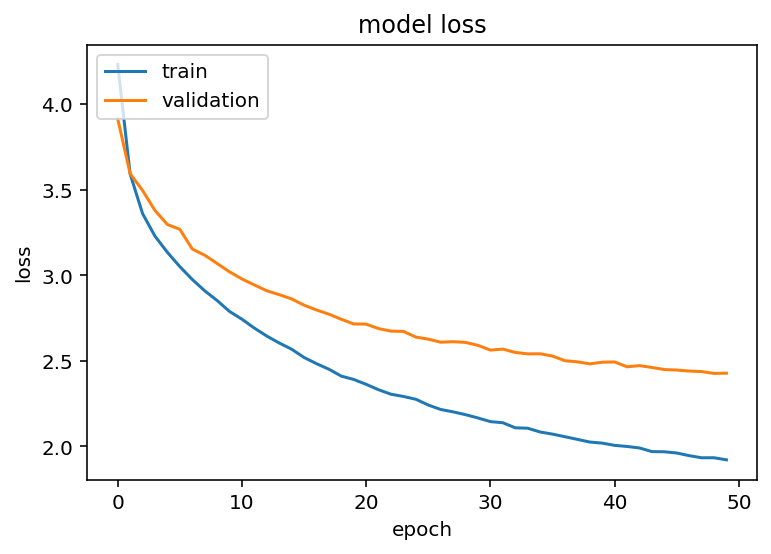

In [38]:
# plots
print(history.history.keys())
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(20):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

1/1 [==============================] - 0s 16ms/step
[10, 14, 10, 126, 10, 126, 90, 14, 14, 19, 19, 58, 24, 58, 24, 58, 24, 58, 126, 126]


In [40]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [41]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [42]:
convert_to_midi(predicted_notes)